This notebook solves the tracking issue by using [SAM2](https://github.com/facebookresearch/segment-anything-2/tree/main).
Here I use the pretrained model to segment the Nuclei in the video.
The output is a mask for each object in each frame and the x,y coordinates centers of each object in each frame.

# Table of Contents for this Notebook
#### 1. Imports
#### 2. Import data
#### 3. get the masks and centers
#### 4. Track multiple objects in the video
#### 5. Track the objects through frames
#### 6. Visualize the tracking and output the data

## 1. Imports

In [1]:
import csv
import gc
import logging
import os
import pathlib
import shutil
import socket
import sys
from datetime import datetime

import imageio
import lancedb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import torch
from csbdeep.utils import Path, normalize
from PIL import Image
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.sam2_image_predictor import SAM2ImagePredictor
from skimage import io
from skimage.measure import label, regionprops
from stardist import fill_label_holes, random_label_cmap
from stardist.data import test_image_nuclei_2d
from stardist.matching import matching_dataset
from stardist.models import StarDist2D
from stardist.plot import render_label
from torchvision import models

sys.path.append("../../../utils/")
from SAM2_utils import (
    delete_recorded_memory_history,
    export_memory_snapshot,
    generate_random_coords,
    show_mask,
    show_points,
    start_record_memory_history,
    stop_record_memory_history,
)

2024-08-23 19:41:03.324612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 19:41:03.335932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 19:41:03.339524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 19:41:03.349031: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 19:41:03.997599: W tensorflow/compiler/tf2

## 2. Import data

### Download the model(s)

In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
# move the model to the correct location
model_path = pathlib.Path("sam2_hiera_tiny.pt").resolve()
new_model_path = pathlib.Path("../../../data/models").resolve() / model_path.name
pathlib.Path(new_model_path.parent).mkdir(parents=True, exist_ok=True)
shutil.move(model_path, new_model_path)

--2024-08-23 19:41:04--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 2600:9000:284a:3000:13:6e38:acc0:93a1, 2600:9000:284a:e800:13:6e38:acc0:93a1, 2600:9000:284a:cc00:13:6e38:acc0:93a1, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2600:9000:284a:3000:13:6e38:acc0:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M  93.9MB/s    in 1.6s    

2024-08-23 19:41:06 (93.9 MB/s) - ‘sam2_hiera_tiny.pt’ saved [155906050/155906050]



PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/data/models/sam2_hiera_tiny.pt')

In [3]:
# load in the model and the predictor
sam2_checkpoint = pathlib.Path("../../../data/models/sam2_hiera_tiny.pt").resolve()
model_cfg = "sam2_hiera_t.yaml"
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

# set the path to the videos
tiff_dir = pathlib.Path(
    "../../../2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_6hr_4ch_MaxIP/"
).resolve(strict=True)
ordered_tiffs = pathlib.Path("../sam2_processing_dir/tiffs/").resolve()
converted_to_video_dir = pathlib.Path("../sam2_processing_dir/pngs/").resolve()
if converted_to_video_dir.exists():
    shutil.rmtree(converted_to_video_dir)

ordered_tiffs.mkdir(parents=True, exist_ok=True)
converted_to_video_dir.mkdir(parents=True, exist_ok=True)

### Get data formatted correctly

In [4]:
# get the list of tiff files in the directory
tiff_files = list(tiff_dir.glob("*.tiff"))
tiff_file_names = [file.stem for file in tiff_files]
# files to df
tiff_df = pd.DataFrame({"file_name": tiff_file_names, "file_path": tiff_files})

# split the file_path column by _ but keep the original column
tiff_df["file_name"] = tiff_df["file_name"].astype(str)
tiff_df[["Well", "FOV", "Timepoint", "Z-slice", "Channel", "illum"]] = tiff_df[
    "file_name"
].str.split("_", expand=True)
tiff_df["Well_FOV"] = tiff_df["Well"] + "_" + tiff_df["FOV"]
# drop all channels except for the first one
tiff_df = tiff_df[tiff_df["Channel"] == "C01"]
tiff_df = tiff_df.drop(columns=["Channel", "illum"])
tiff_df["new_path"] = (
    str(ordered_tiffs)
    + "/"
    + tiff_df["Well_FOV"]
    + "/"
    + tiff_df["file_name"]
    + ".tiff"
)
tiff_df.reset_index(drop=True, inplace=True)
tiff_df.head()

file_name  \
0  C-02_F0002_T0006_Z0001_C01_illumcorrect   
1  E-11_F0004_T0007_Z0001_C01_illumcorrect   
2  E-11_F0003_T0002_Z0001_C01_illumcorrect   
3  C-02_F0002_T0010_Z0001_C01_illumcorrect   
4  C-02_F0003_T0012_Z0001_C01_illumcorrect   

                                           file_path  Well    FOV Timepoint  \
0  /home/lippincm/Documents/live_cell_timelapse_a...  C-02  F0002     T0006   
1  /home/lippincm/Documents/live_cell_timelapse_a...  E-11  F0004     T0007   
2  /home/lippincm/Documents/live_cell_timelapse_a...  E-11  F0003     T0002   
3  /home/lippincm/Documents/live_cell_timelapse_a...  C-02  F0002     T0010   
4  /home/lippincm/Documents/live_cell_timelapse_a...  C-02  F0003     T0012   

  Z-slice    Well_FOV                                           new_path  
0   Z0001  C-02_F0002  /home/lippincm/Documents/live_cell_timelapse_a...  
1   Z0001  E-11_F0004  /home/lippincm/Documents/live_cell_timelapse_a...  
2   Z0001  E-11_F0003  /home/lippincm/Documents/live_cell_timelapse_a...  
3   Z0001  C-02_F0002  /home/lippincm/Documents/live_cell_timelapse_a...  
4   Z0001  C-02_F0003  /home/lippincm/Documents/live_cell_timelapse_a...

In [5]:
# copy the files to the new directory
# from file path to new path
for index, row in tiff_df.iterrows():
    new_path = pathlib.Path(row["new_path"])
    new_path.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy(row["file_path"], new_path)

In [6]:
# get the list of directories in the ordered tiffs directory
ordered_tiff_dirs = list(ordered_tiffs.glob("*"))
ordered_tiff_dir_names = [dir for dir in ordered_tiff_dirs]
ordered_tiff_dir_names
for dir in ordered_tiff_dir_names:
    out_dir = converted_to_video_dir / dir.name
    out_dir.mkdir(parents=True, exist_ok=True)
    for tiff_file in dir.glob("*.tiff"):
        jpeg_file = pathlib.Path(f"{out_dir}/{tiff_file.stem}.jpeg")

        if not jpeg_file.exists():
            try:
                with Image.open(tiff_file) as img:
                    # Convert the image to 8-bit per channel
                    img = img.convert("L")
                    img.save(jpeg_file)
            except Exception as e:
                print(f"Failed to convert {tiff_file}: {e}")

In [8]:
# get list of dirs in the converted to video dir
converted_dirs = list(converted_to_video_dir.glob("*"))
converted_dir_names = [dir for dir in converted_dirs]
for dir in converted_dir_names:
    dir = sorted(dir.glob("*.jpeg"))
    for i in enumerate(dir):
        # rename the files to be in order
        i[1].rename(f"{dir[0].parent}/{str(i[0] + 1).zfill(3)}.jpeg")

### Donwsample each frame to fit the images on the GPU - overwrite the copies JPEGs

In [9]:
# get files in the directory
converted_dirs_list = list(converted_to_video_dir.rglob("*"))
converted_dirs_list = [f for f in converted_dirs_list if f.is_file()]
# posix path to string
files = [str(f) for f in converted_dirs_list]

In [10]:
# sort the files by name
# downsample the image
for f in files:
    img = io.imread(f)
    # downsample the image
    downsampled_img = img[::10, ::10]
    # save the downsampled image in place of the original image
    io.imsave(f, downsampled_img)

## 3. Get initial masks and centers via StarDist

### Get the first frame of each video
### Set up a dict that holds the images path, the first frame_mask, and the first frame_centers

In [17]:
# where one image set here is a single well and fov over all timepoints
image_set_dict = {
    "image_set_name": [],
    "image_set_path": [],
    "image_set_first_frame": [],
    "image_x_y_coords": [],
    "image_labels": [],
}

# get the list of directories in the ordered tiffs directory
dirs = list(converted_to_video_dir.glob("*"))
dirs = [dir for dir in dirs if dir.is_dir()]
for dir in dirs:
    # get the files in the directory
    files = sorted(dir.glob("*.jpeg"))
    image_set_dict["image_set_name"].append(dir.name)
    image_set_dict["image_set_path"].append(str(dir))
    image_set_dict["image_set_first_frame"].append(files[0])

### Plot the segementation
Plot the following:
- the original image
- the segmentation
- the x,y centers of the segmentation
- the extracted masks

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
E-11_F0001: /home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP_attempt/run_sam/sam2_processing_dir/pngs/E-11_F0001/01.jpeg
C-02_F0002: /home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP_attempt/run_sam/sam2_processing_dir/pngs/C-02_F0002/01.jpeg
C-02_F0001: /home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP_attempt/run_sam/sam2_processing_dir/pngs/C-02_F0001/01.jpeg
E-11_F0003: /home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP_attempt/run_sam/sam2_processing_dir/pngs/E-11_F0003/01.jpeg
C-02_F0003: /home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP_attempt/run_sam/sam2_processing_dir/pngs/C-02_F0003/01.jpeg
C-02_F0004: /home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP_a

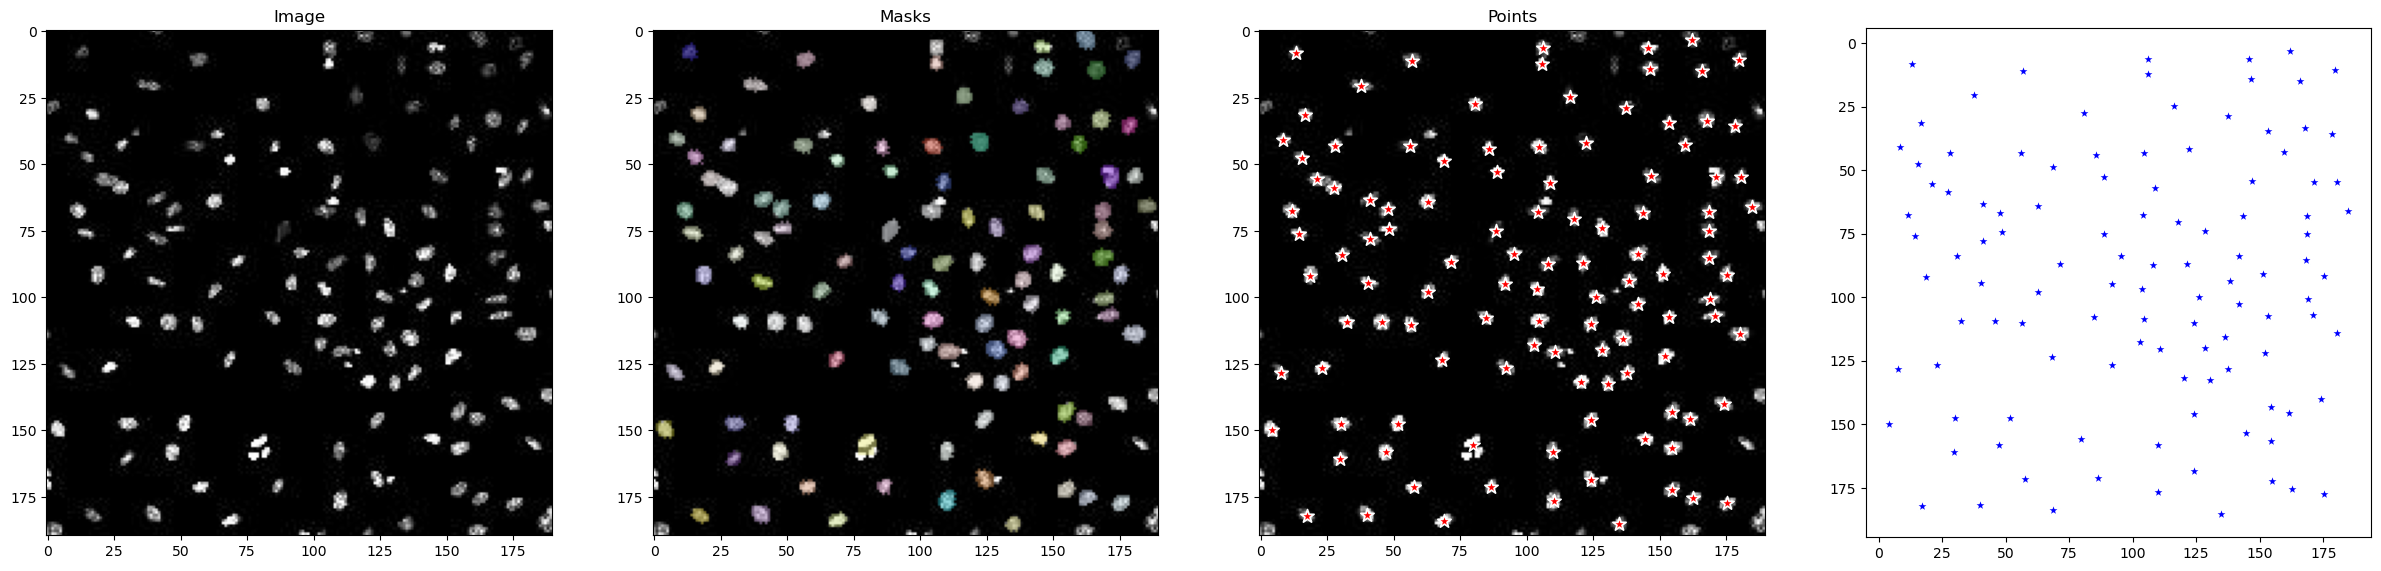

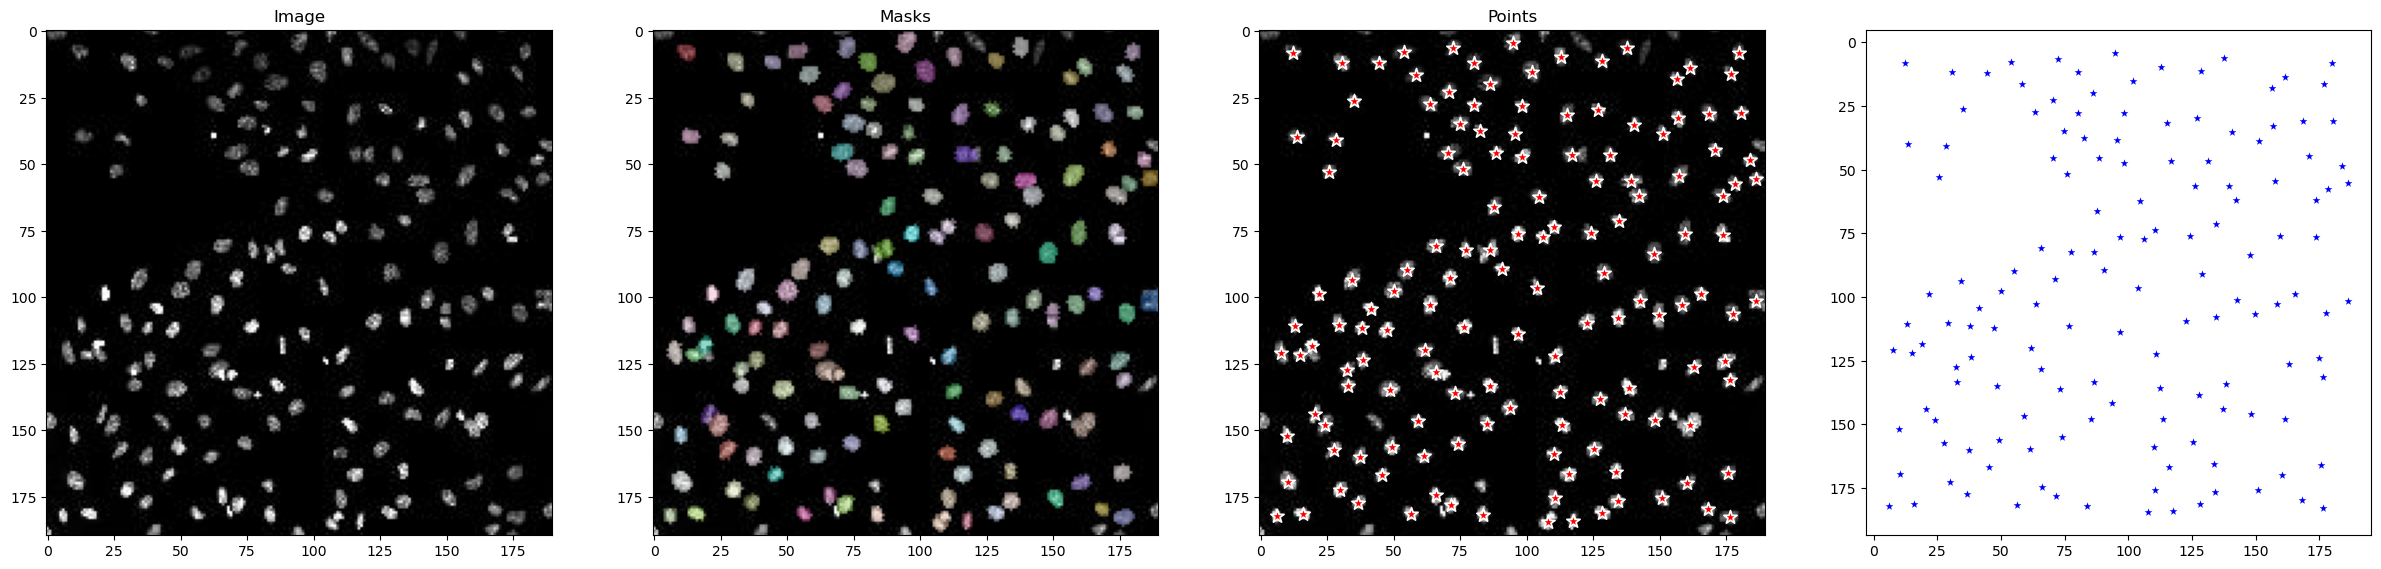

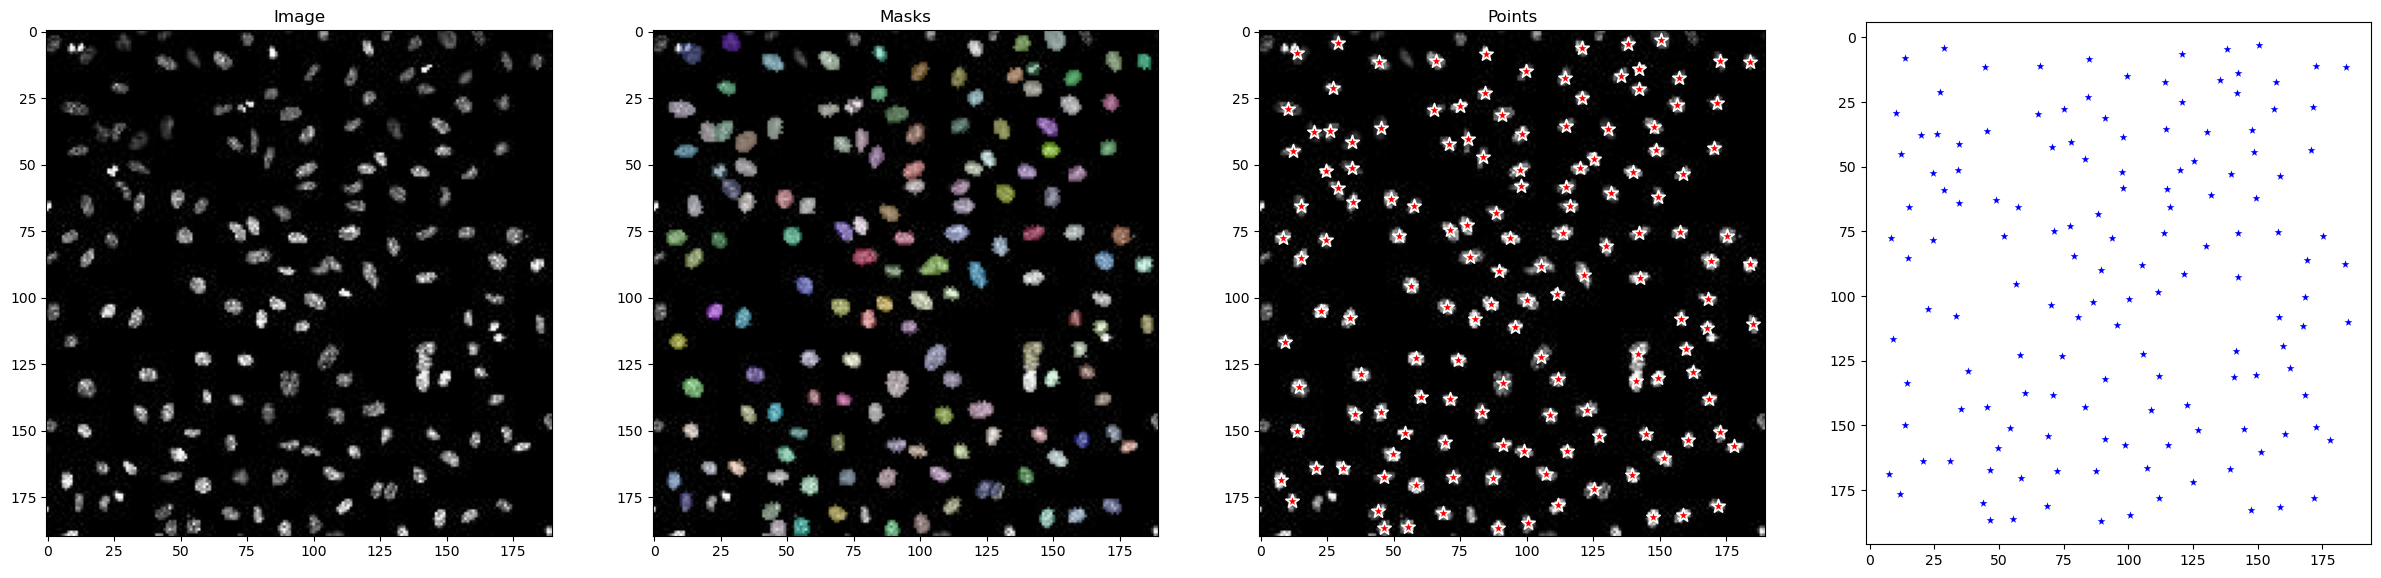

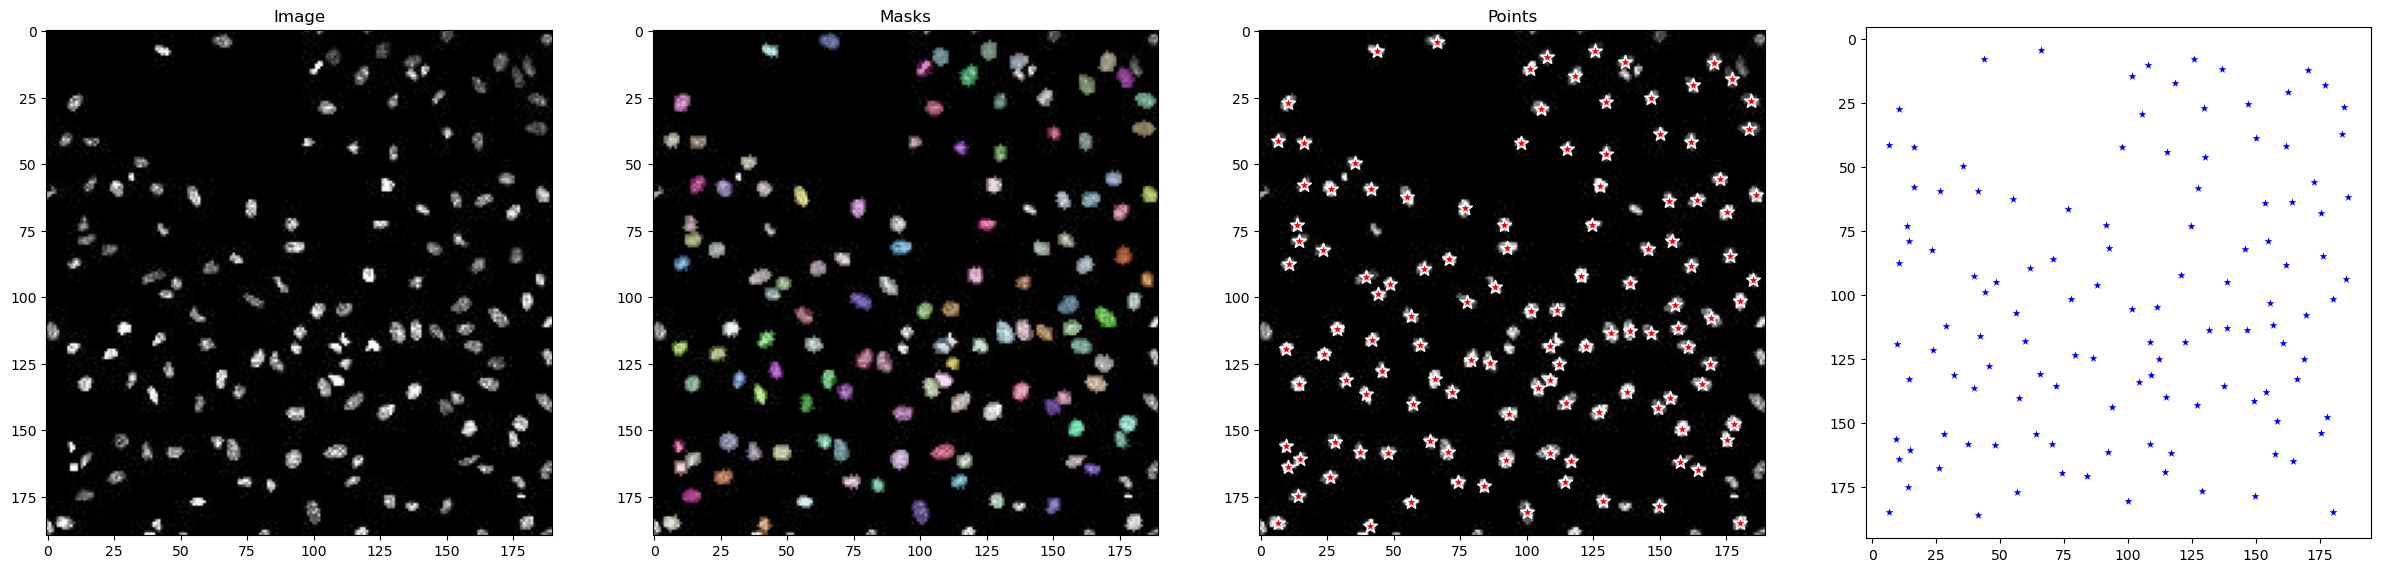

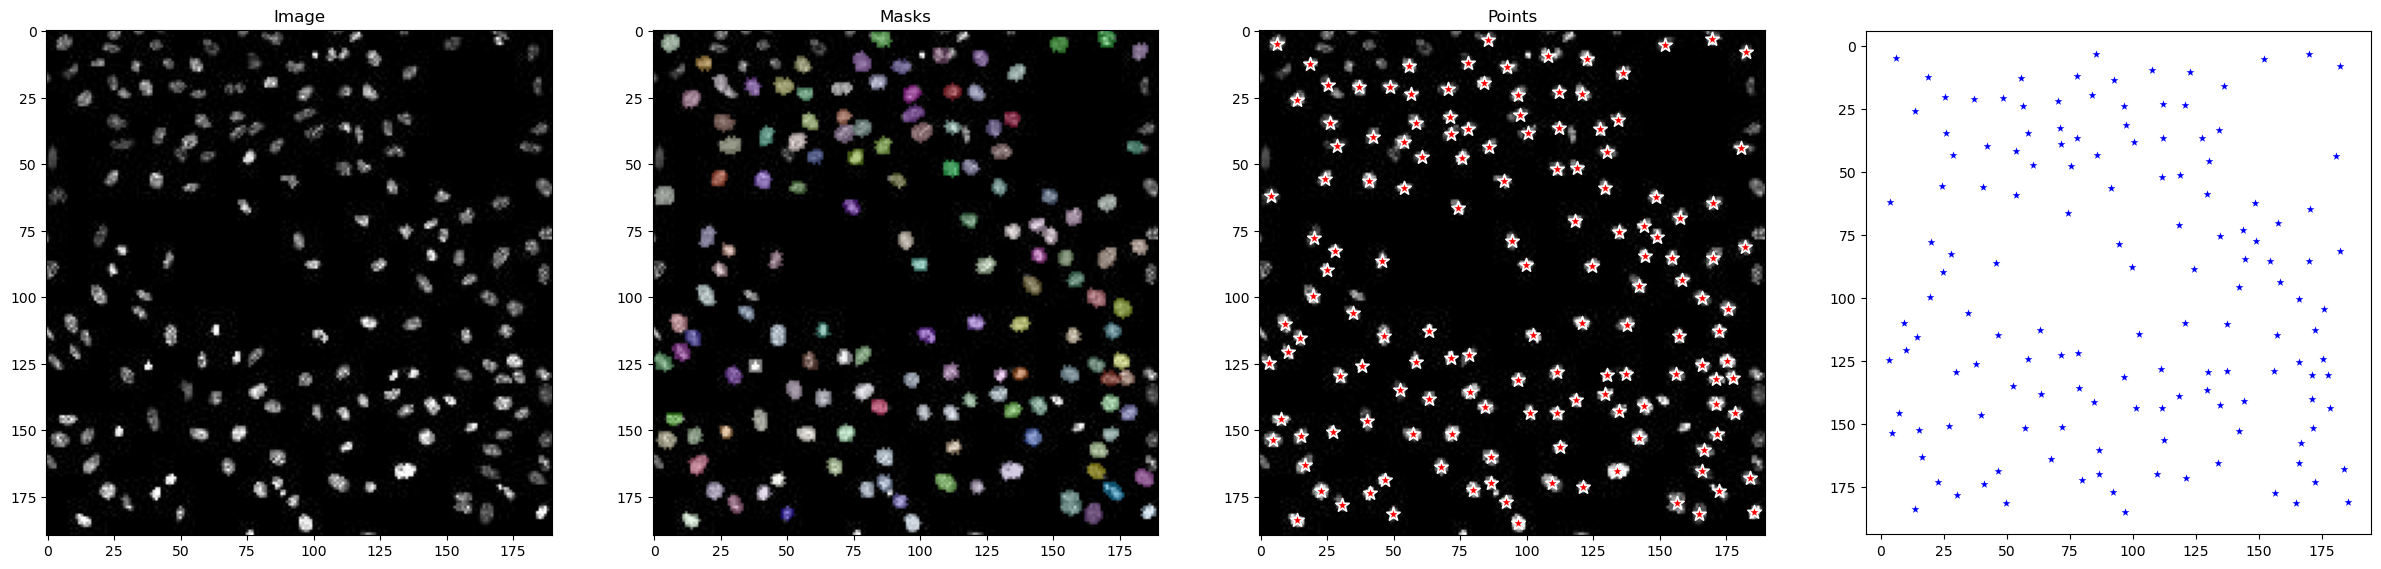

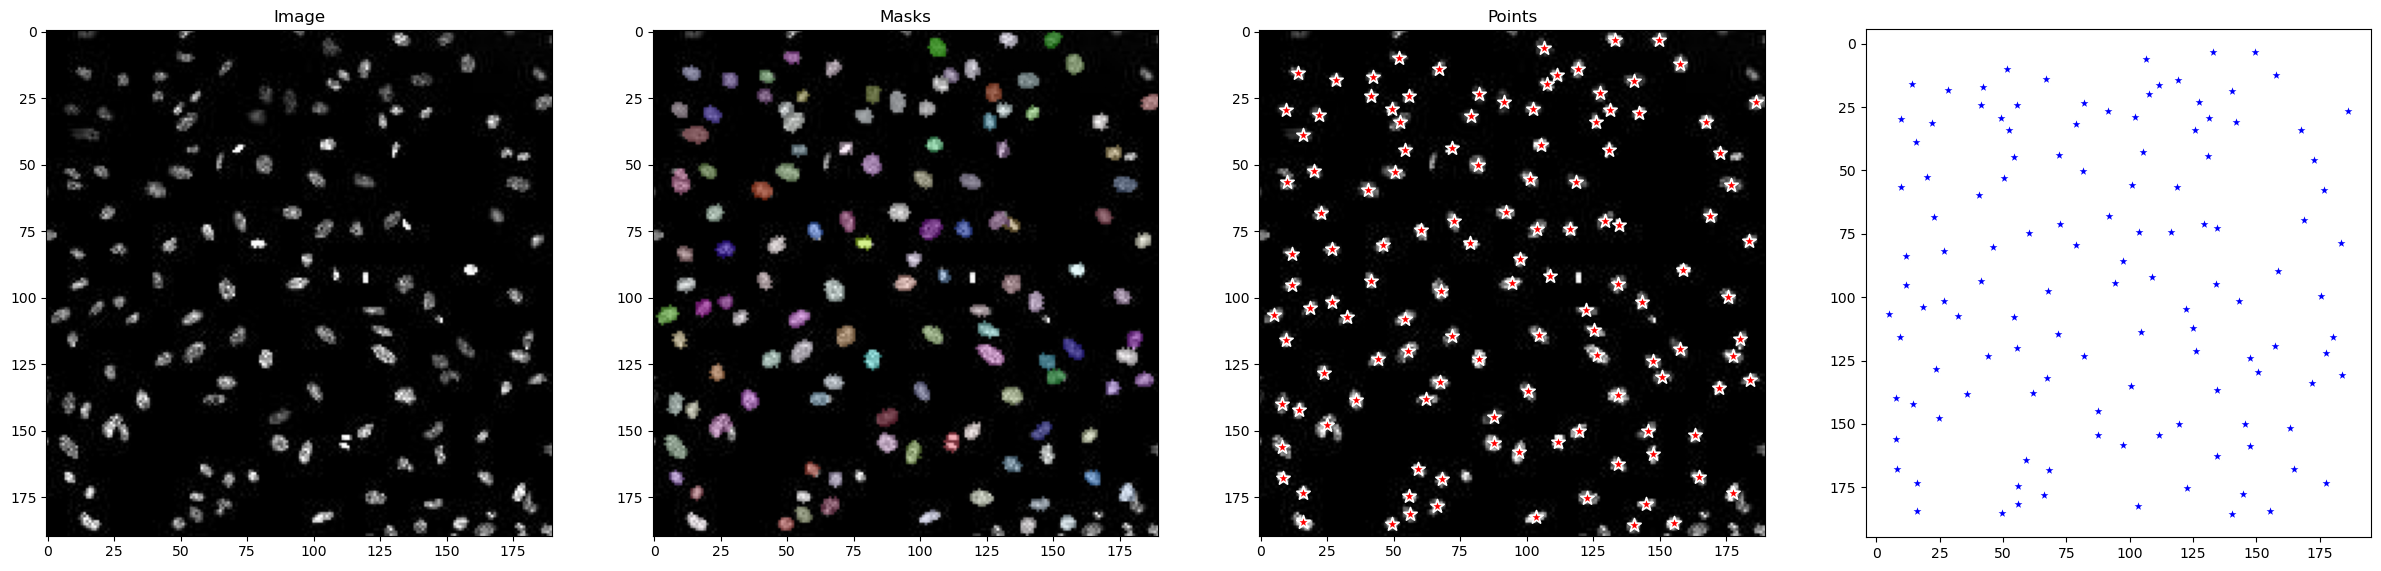

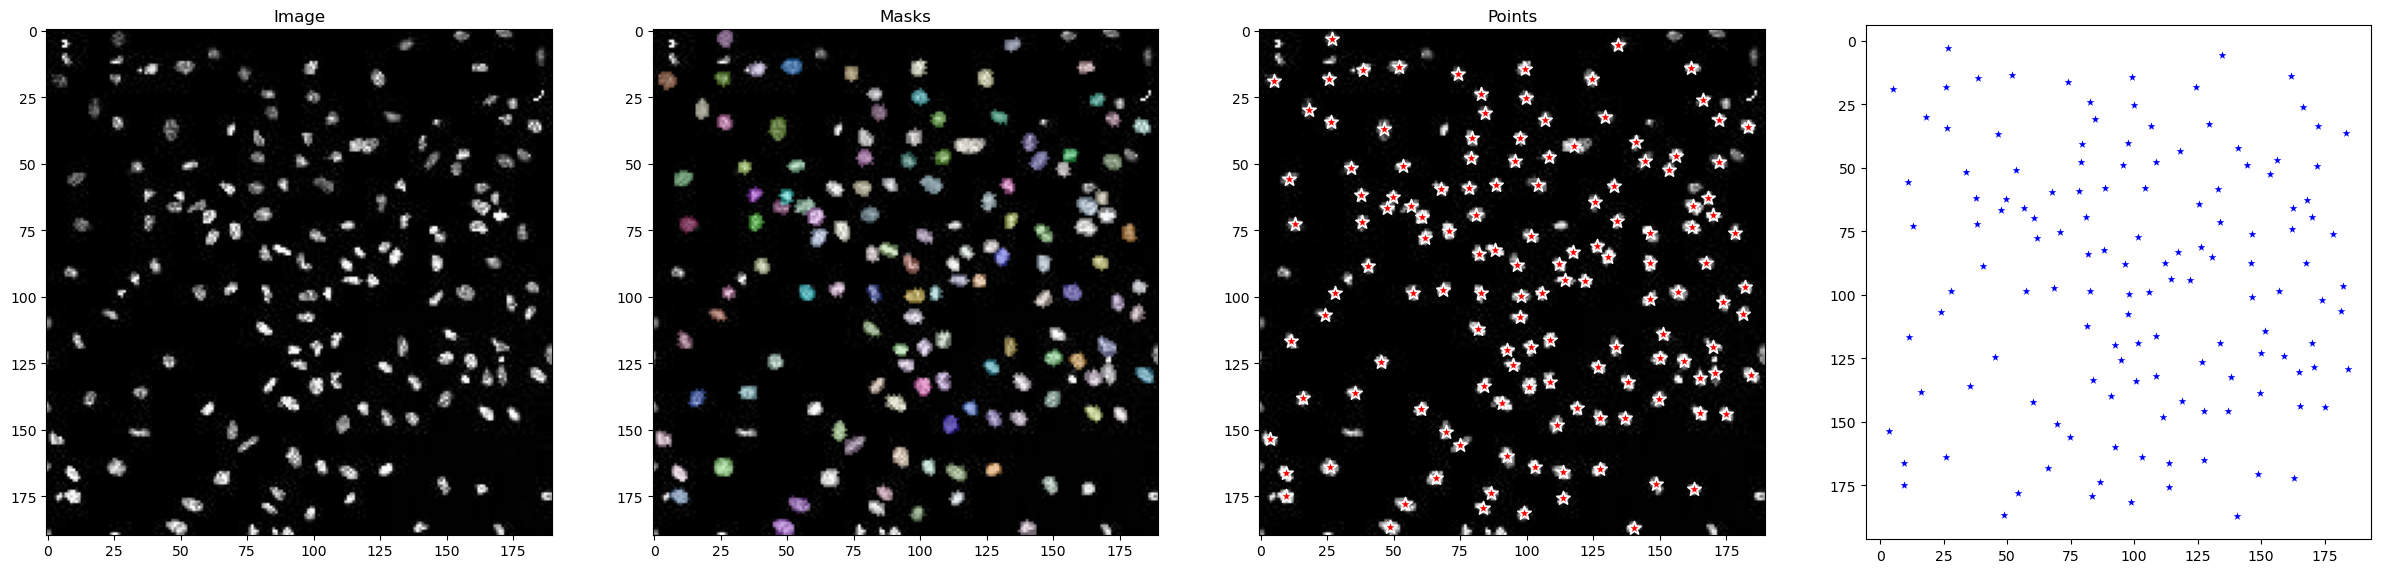

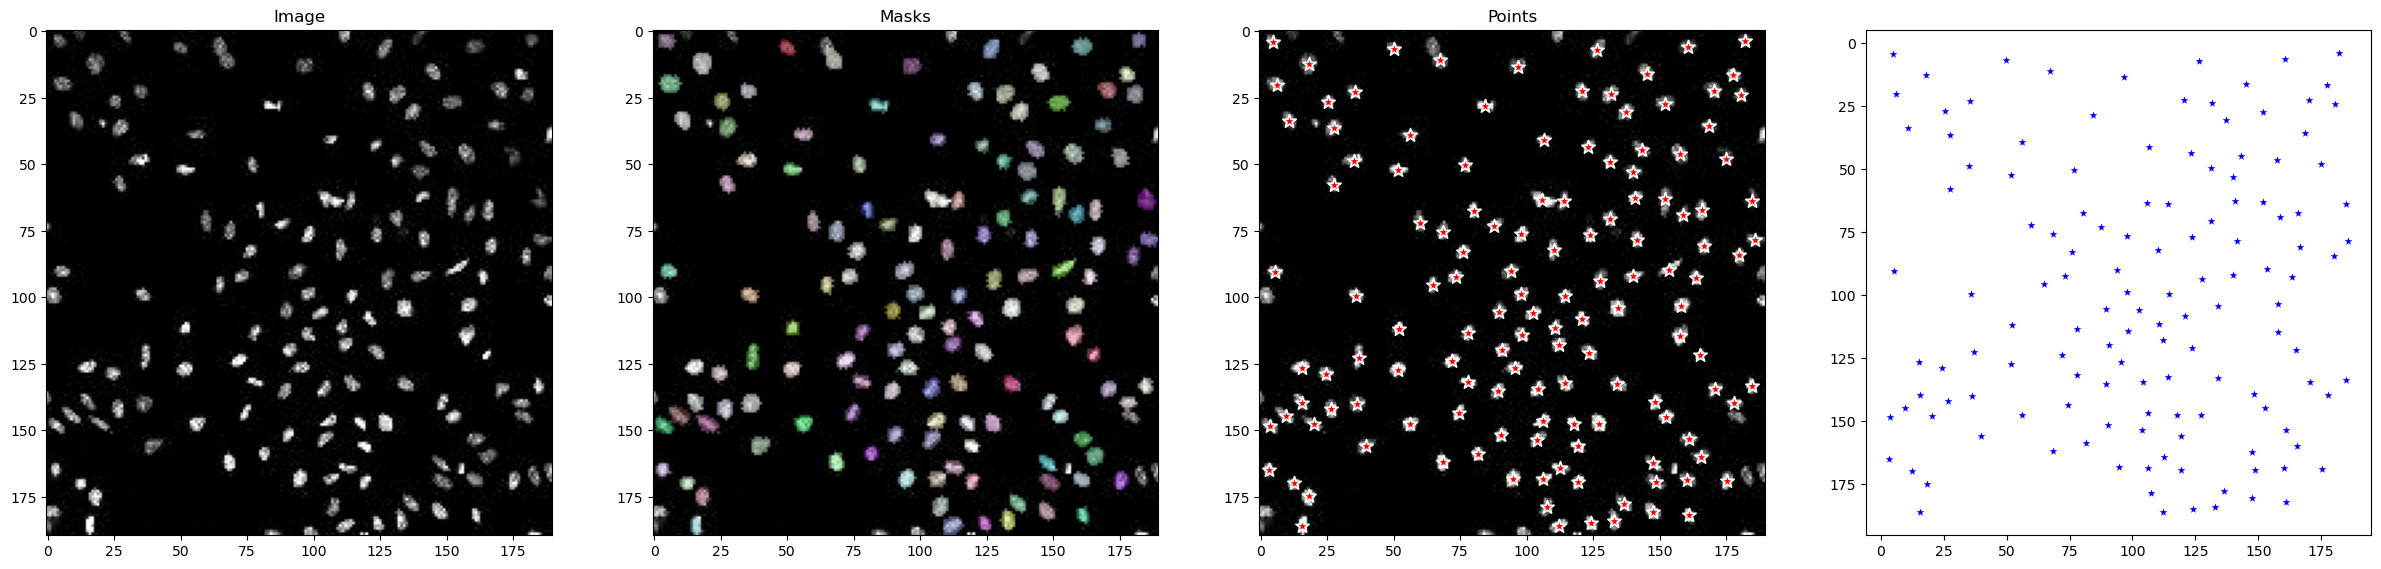

In [18]:
model = StarDist2D.from_pretrained("2D_versatile_fluo")

# loop through each image set and predict the instances
for i in range(len(image_set_dict["image_set_name"])):
    print(
        f"{image_set_dict['image_set_name'][i]}: {image_set_dict['image_set_first_frame'][i]}"
    )
    img = io.imread(image_set_dict["image_set_first_frame"][i])
    labels, _ = model.predict_instances(normalize(img))
    # convert the labels into position coordinates
    regions = regionprops(label(labels))
    coords = np.array([r.centroid for r in regions])

    # plot the points and the masks and the image side by side by side
    fig, ax = plt.subplots(1, 4, figsize=(30, 15))
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title("Image")
    ax[1].imshow(render_label(labels, img=img))
    ax[1].set_title("Masks")
    ax[2].imshow(img, cmap="gray")
    ax[2].scatter(
        coords[:, 1],
        coords[:, 0],
        color="red",
        marker="*",
        s=100,
        edgecolor="white",
        linewidth=1.25,
    )
    ax[2].set_title("Points")
    coords = coords[:, [1, 0]]
    ax[3].invert_yaxis()
    # make the aspect ratio equal
    ax[3].set_aspect("equal")
    show_points(coords, np.ones(len(coords)), ax[3])
    labels = np.ones(coords.shape[0], dtype=np.int32)
    image_set_dict["image_x_y_coords"].append(coords)
    image_set_dict["image_labels"].append(labels)

## 4. Track multiple objects in the video

In [ ]:
# initialize the state
inference_state = predictor.init_state(
    video_path=str(video_dir), offload_video_to_cpu=True, offload_state_to_cpu=True
)
predictor.reset_state(inference_state)

In [ ]:
# get the first frame coords
points = coords
labels = np.ones(coords.shape[0], dtype=np.int32)
print(points.shape, labels.shape)

In [ ]:
prompts = {}
ann_frame_idx = 0
ann_obj_idx = 1
samples = 1
negative_sampling = False  # set True to generate negative samples for better training
# loop through the points and add them to the state and get the masks
for point, _label in zip(points, labels):
    _label = np.array([_label], dtype=np.int32)
    point = np.array([point], dtype=np.float32)
    random_points, random_labels = generate_random_coords(
        img=img, coords=point, samples=samples
    )
    if negative_sampling:
        point = np.concatenate([point, random_points], axis=0)
        _label = np.concatenate([_label, random_labels], axis=0)
    # add the points to the state
    _, out_obj_ids, out_mask_logits = predictor.add_new_points(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_idx,
        points=point,
        labels=_label,
    )
    # save the prompts
    prompts[ann_obj_idx] = {
        "points": point,
        "labels": _label,
        "out_obj_ids": out_obj_ids[0],
        "out_mask_logits": out_mask_logits[0].detach().cpu().numpy(),
    }
    # increment the object index for this frame
    ann_obj_idx += 1

In [ ]:
# show the results on the current (interacted) frame
plt.figure(figsize=(15, 15))
# subplot axis
# show the frame
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# subplot for each object
for i, out_obj_id in enumerate(range(1, ann_obj_idx)):
    tmp_coords = prompts[out_obj_id]["points"]
    tmp_labels = prompts[out_obj_id]["labels"]
    # add title to the subplot
    plt.title(f"Object {out_obj_id}")
    # show the frame
    show_points(tmp_coords, tmp_labels, plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)
plt.show()

## 5. Track the objects through frames

In [ ]:
print(ann_obj_idx)
# Start recording memory snapshot history
logging.basicConfig(
    format="%(levelname)s:%(asctime)s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"

# Keep a max of 100,000 alloc/free events in the recorded history
# leading up to the snapshot.
MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT: int = 100000
start_record_memory_history(
    logger=logger, max_entries=MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT
)
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results

for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
    inference_state
):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(range(1, ann_obj_idx))
    }

In [ ]:
# delete any prior memory profiling data
delete_recorded_memory_history(
    logger=logger, save_dir=pathlib.Path("../memory_snapshots/").resolve()
)
# clear the memory
del out_mask_logits
del out_obj_ids
del out_frame_idx
torch.cuda.empty_cache()
gc.collect()
# save the memory snapshot to a file
export_memory_snapshot(
    logger=logger, save_dir=pathlib.Path("../memory_snapshots/").resolve()
)
stop_record_memory_history(logger=logger)

In [ ]:
# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
rows = 5
cols = int(np.ceil(len(frame_names) / rows))
fig, ax = plt.subplots(rows, cols, figsize=(30, 30))
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    row, col = divmod(out_frame_idx, cols)
    # add title to the subplot
    ax[row, col].set_title(f"Frame {out_frame_idx}")
    ax[row, col].imshow(
        Image.open(os.path.join(video_dir, frame_names[out_frame_idx])), cmap="gray"
    )
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        # plt.plot(points[0][1], points[0][0], 'o', color='red')
        # show_points(points, labels, ax[row, col])
        show_mask(mask=out_mask, ax=ax[row, col], obj_id=out_obj_id)

## 6. Visualize the tracking and output the data

In [ ]:
# add all of the frames together for a rendered gif
# create a list of all the frames
frames = []
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    # create a figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(
        Image.open(os.path.join(video_dir, frame_names[out_frame_idx])), cmap="gray"
    )
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(mask=out_mask, ax=ax, obj_id=out_obj_id)
    # add title to the subplot
    ax.set_title(f"Frame {out_frame_idx}")
    # save the figure to a file
    fig.savefig(f"tmp_{out_frame_idx}.png")
    # close the figure
    plt.close(fig)
    # open the image
    img = Image.open(f"tmp_{out_frame_idx}.png")
    # append the image to the frames
    frames.append(img)

fig_path = pathlib.Path("../masks/out.gif").resolve()
pathlib.Path("../masks/").mkdir(exist_ok=True, parents=True)
# save the frames as a gif
frames[0].save(fig_path, save_all=True, append_images=frames[1:], duration=10, loop=0)

# get all files that have tmp in the name
tmp_files = list(Path(".").glob("tmp*.png"))
# delete all the tmp files
[f.unlink() for f in tmp_files]

In [ ]:
img = io.imread(frame_names[0])
h, w = img.shape
print(h, w)
# extract the masks from the video segments
# save the masks to a directory
masks_dir = pathlib.Path("../masks").resolve()
masks_dir.mkdir(exist_ok=True)
for out_frame_idx, frame_masks in video_segments.items():
    # make the frame image
    frame_image = np.zeros((h, w), dtype=np.uint8)
    for out_obj_id, out_mask in frame_masks.items():
        # add each mask to the frame image
        frame_image += (out_mask[0] * 255).astype(np.uint8)
    # save the frame image
    frame_image = Image.fromarray(frame_image)
    frame_image.save(masks_dir / f"{out_frame_idx}.png")

In [ ]:
# extract x,y center of mass of the masks with object id
# save the x,y center of mass to a csv file
csv_file = pathlib.Path("../masks/masks.csv").resolve()
with open(csv_file, mode="w") as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(["frame", "obj_id", "x", "y"])
    for out_frame_idx, frame_masks in video_segments.items():
        for out_obj_id, out_mask in frame_masks.items():
            out_mask = np.array(out_mask[0], dtype=np.float32)
            # convert the outmask to an image
            regions = regionprops(label(out_mask))
            for region in regions:
                y, x = region.centroid
                csv_writer.writerow([out_frame_idx, out_obj_id, x, y])


df = pd.read_csv(csv_file)
df.head()